# Create dataset

In [1]:
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000
x,y = make_circles(n_samples, noise = 0.03, random_state = 1)

# Visualize dataset

In [3]:
import pandas as pd

In [4]:
circles = pd.DataFrame({
    "x1": x[:, 0],
    "x2": x[:, 1],
    "label": y
})

In [5]:
circles.head(10)

,x1,x2,label
0,0.836198,0.035631,1
1,-0.530598,-0.648715,1
2,0.853869,-0.611566,0
3,-0.092147,-0.965144,0
4,-1.001623,0.144467,0
5,0.476053,-0.611694,1
6,-0.963053,-0.154417,0
7,-0.541585,-0.531194,1
8,-0.705709,-0.635493,0
9,0.835799,0.580793,0


In [6]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

# Plot dataset

In [7]:
import matplotlib.pyplot as plt

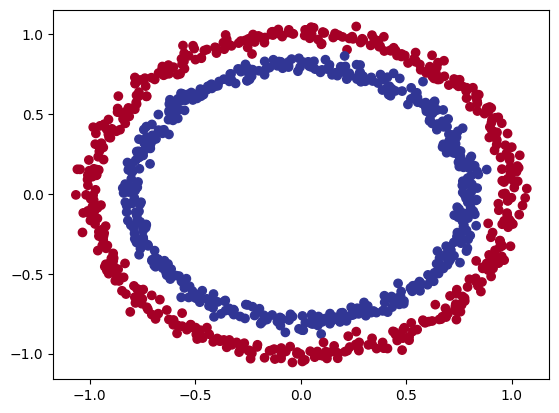

In [8]:
plt.scatter(
    x=x[:,0],
    y=x[:,1],
    c=y,
    cmap=plt.cm.RdYlBu
)

This is a toy dataset <br>
It doesn't contain real data, but emulate it to propose a challenging problem useful to test machine learning algorithms

In [9]:
print(x[0], x.shape)
print(y[0], y.shape)

[0.83619806 0.03563148] (1000, 2)
1 (1000,)


# Prepare data to use in pytorch

In [10]:
import torch

In [11]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
print(x[0], x.shape)
print(y[0], y.shape)

tensor([0.8362, 0.0356]) torch.Size([1000, 2])
tensor(1.) torch.Size([1000])


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
xt, xv, yt, yv = train_test_split(
    x,
    y,
    test_size = 0.2,
    random_state=0
)
print(len(xt),len(yt),len(xv),len(yv))

800 800 200 200


# Set up device agnostic code

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


# Build model from nn.Module

In [16]:
from torch import nn

In [17]:
class PredictCircleModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = 2, out_features = 5)
        self.layer2 = nn.Linear(in_features = 5, out_features = 1)

    def forward(self, x):
        return self.layer2(self.layer1(x))

In [18]:
model = PredictCircleModule().to(device)
print(model)

PredictCircleModule(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)


In [19]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0854, -0.2759],
         [-0.2116,  0.6049],
         [-0.1680, -0.5811],
         [-0.0556, -0.0131],
         [ 0.3319,  0.7061]], requires_grad=True),
 Parameter containing:
 tensor([-0.3578, -0.5897, -0.4593,  0.3065,  0.6881], requires_grad=True),
 Parameter containing:
 tensor([[-0.2084, -0.1690,  0.1184, -0.3598,  0.1061]], requires_grad=True),
 Parameter containing:
 tensor([-0.0440], requires_grad=True)]

In [20]:
yp = model(xt.to(device))
print(yp.shape, yt.shape)
print(yp[:5], yt[:5])

torch.Size([800, 1]) torch.Size([800])
tensor([[ 0.0150],
        [-0.0100],
        [ 0.0712],
        [-0.0441],
        [-0.0334]], grad_fn=<SliceBackward0>) tensor([1., 1., 1., 0., 1.])


# Define loss function, optimizer, and evaluation metric

In [21]:
loss = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(
    params = model.parameters(),
    lr = 0.1
)

In [22]:
def accuracy(yp, y):
    correct = torch.eq(y, yp).sum().item()
    return (correct / len(yp)) * 100

## Observation about logits

In [23]:
logits = model(xt.to(device))
print(logits[:5])

tensor([[ 0.0150],
        [-0.0100],
        [ 0.0712],
        [-0.0441],
        [-0.0334]], grad_fn=<SliceBackward0>)


In [24]:
yp = torch.sigmoid(logits)
print(yp[:5])

tensor([[0.5038],
        [0.4975],
        [0.5178],
        [0.4890],
        [0.4917]], grad_fn=<SliceBackward0>)


In [25]:
yp = torch.round(torch.sigmoid(logits))
print(yp[:5])

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [0.]], grad_fn=<SliceBackward0>)


In [26]:
print(yp.squeeze()[:5])
print(yv[:5])

tensor([1., 0., 1., 0., 0.], grad_fn=<SliceBackward0>)
tensor([1., 1., 0., 1., 1.])


# Create training loop

## Step by step

### Forward pass
Pass an input, compute the forward function, store the results

In [27]:
model.train()
logits = model(xt.to(device)).squeeze()
yp = torch.round(torch.sigmoid(logits))

### Calculate the cost
Compare the results to the truth-table and calculate the cost

In [28]:
cost = loss(logits, yt)

### Reset gradients
Since pytorch natively aggregates gradients, you must reset them for your use case

In [29]:
optim.zero_grad()

### Backpropagate the loss
Use the computed loss to calculate the gradient of each parameter

In [30]:
cost.backward()

### Improve the parameters
Use the computed gradients to update the parameters

In [31]:
optim.step()

### Measure accuracy
Evaluate how the updated model is performing

In [32]:
model.eval()
with torch.inference_mode():
    logits = model(xv).squeeze()
    yp = torch.round(torch.sigmoid(logits))
    cost = loss(logits, yv)
    acc = accuracy(yp, yv)
print(f"Loss: {cost:.5f} | Accuracy: {acc:.2f}")

Loss: 0.69172 | Accuracy: 56.50


## Complete

In [33]:
epochs = 100
costs = []
accuracies = []

for epoch in range(epochs):
    model.train()
    # forward pass
    logits = model(xt.to(device)).squeeze()
    yp = torch.round(torch.sigmoid(logits))
    # calculate the cost
    cost = loss(logits, yt)
    # reset gradients
    optim.zero_grad()
    # backpropagate the loss
    cost.backward()
    # improve the parameters
    optim.step()
    # measure accuracy
    model.eval()
    with torch.inference_mode():
        logits = model(xv).squeeze()
        yp = torch.round(torch.sigmoid(logits))
        cost = loss(yp, yv)
        acc = accuracy(yp, yv)
        if epoch % 10 == 0:
            costs.append(cost)
            accuracies.append(acc)
            print(f"Epoch: {epoch} | Loss: {cost:.5f} | Accuracy: {acc:.2f}")
        

Epoch: 0 | Loss: 0.73522 | Accuracy: 56.00
Epoch: 10 | Loss: 0.73181 | Accuracy: 55.00
Epoch: 20 | Loss: 0.73770 | Accuracy: 52.50
Epoch: 30 | Loss: 0.73840 | Accuracy: 52.00
Epoch: 40 | Loss: 0.73720 | Accuracy: 52.00
Epoch: 50 | Loss: 0.73600 | Accuracy: 52.00
Epoch: 60 | Loss: 0.73290 | Accuracy: 52.50
Epoch: 70 | Loss: 0.73290 | Accuracy: 52.50
Epoch: 80 | Loss: 0.73290 | Accuracy: 52.50
Epoch: 90 | Loss: 0.73600 | Accuracy: 52.00


## Warning
I commited a mistake. The cost could not be backpropagated due to a rounding function being applied. The rounding function makes the whole calculation non-linear.

```python
# wrong
logits = model(xt.to(device)).squeeze()
yp = torch.round(torch.sigmoid(logits))
cost = loss(yp, yt)

# right
logits = model(xt.to(device)).squeeze()
yp = torch.round(torch.sigmoid(logits))
cost = loss(logits, yt)
```

## Plotting decision boundary

In [51]:
x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1

In [52]:
import numpy as np

In [53]:
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.meshgrid(np.linspace(y_min, y_max, 100)))

In [54]:
x_mesh = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float)

In [55]:
yp_mesh = model(x_mesh)

In [56]:
yp_mesh = torch.round(yp_mesh).reshape(xx.shape)

(-1.1554518938064575, 1.1468466520309448)

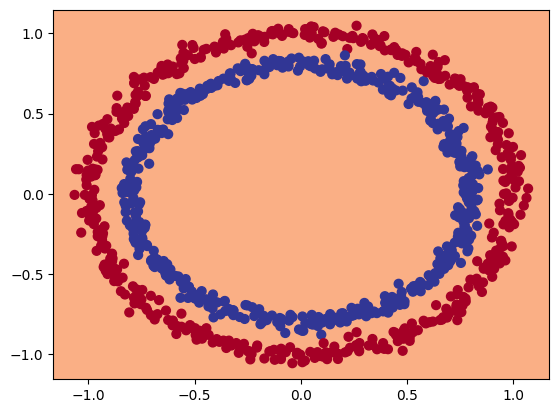

In [57]:
plt.contourf(xx, yy, yp_mesh.detach().numpy(), cmap=plt.cm.RdYlBu, alpha=0.7 )
plt.scatter(x[:,0], x[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())